### HST

/mnt/D/JWST_data/COSMOS-Webb/others/HST/acs_I_030mas_066_sci.fits


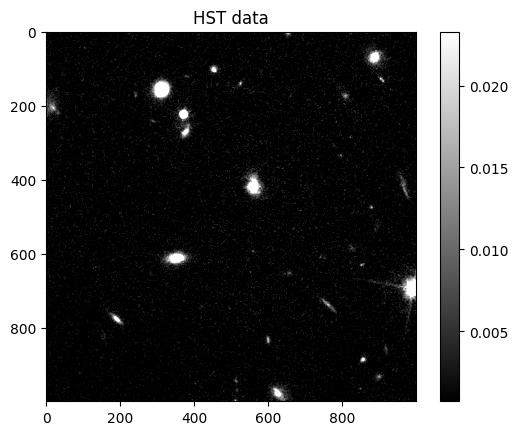

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


# find all HST fits.gz files
import glob
files = sorted(glob.glob('/mnt/D/JWST_data/COSMOS-Webb/others/HST/*066*.fits'))

for gz_file in files:
    print(gz_file)
    
    try:
        # open the file
        with fits.open(gz_file) as hdul:
            data = hdul[0].data
            header = hdul[0].header
            hdul.writeto(gz_file[:-3], overwrite=True)

        data = data[500:1500, 500:1500]
        # plot the data
        plt.imshow(data, 
                cmap='gray',
                vmin=np.nanpercentile(data, 60),
                vmax=np.nanpercentile(data, 99.5)
                )
        plt.title('HST data')
        plt.colorbar()
        plt.show()
        
    except Exception as e:
        print(str(e))
        pass

In [ ]:
from definitions import map_HST_data
import os 

resolution = "30mas"
for area in ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10"]:
    if not os.path.exists(f"./HST_mapping/{resolution}_{area}.json"):
        try:
            map_HST_data(area)
        except Exception as e:
            # print(str(e))
            pass

Calculating offsets between acs_I_030mas_067_sci.fits & A1......
Start crossmatching......
Crossmatching done......


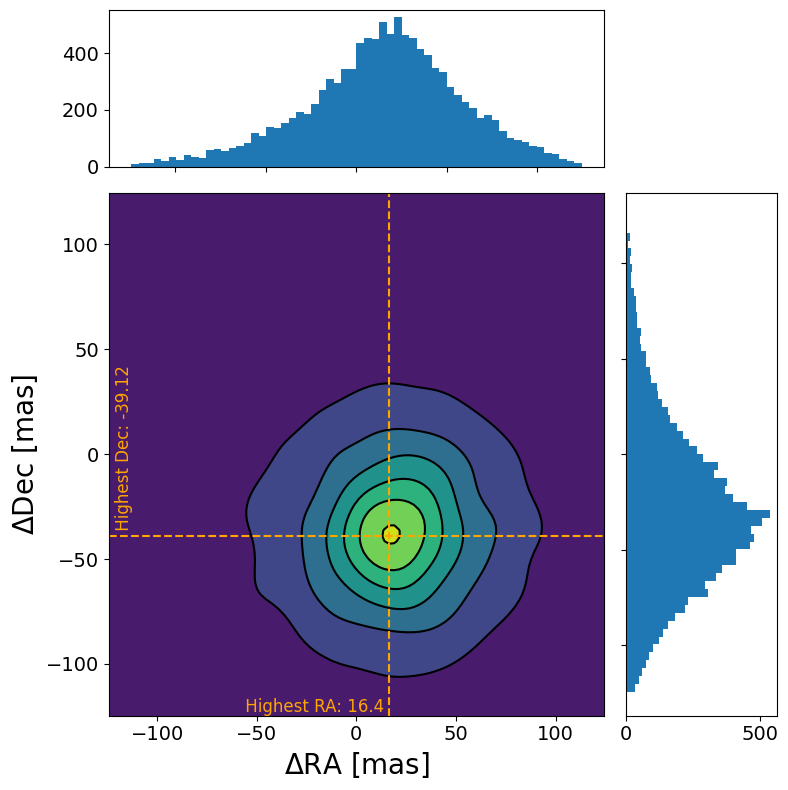

Calculating offsets between acs_I_030mas_079_sci.fits & A1......
Start crossmatching......
Crossmatching done......


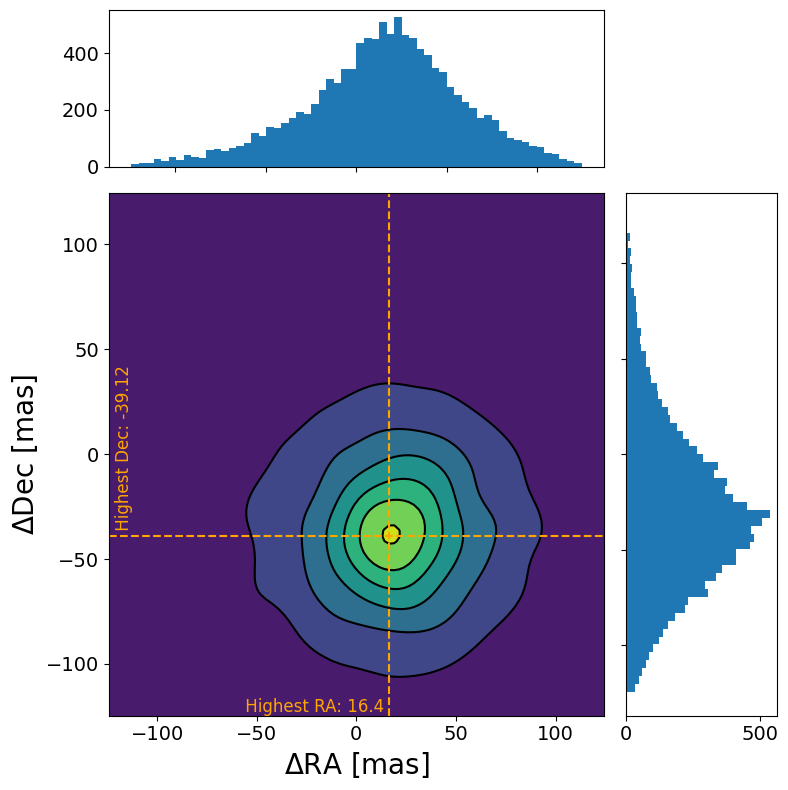

Calculating offsets between acs_I_030mas_055_sci.fits & A1......
Start crossmatching......
Crossmatching done......


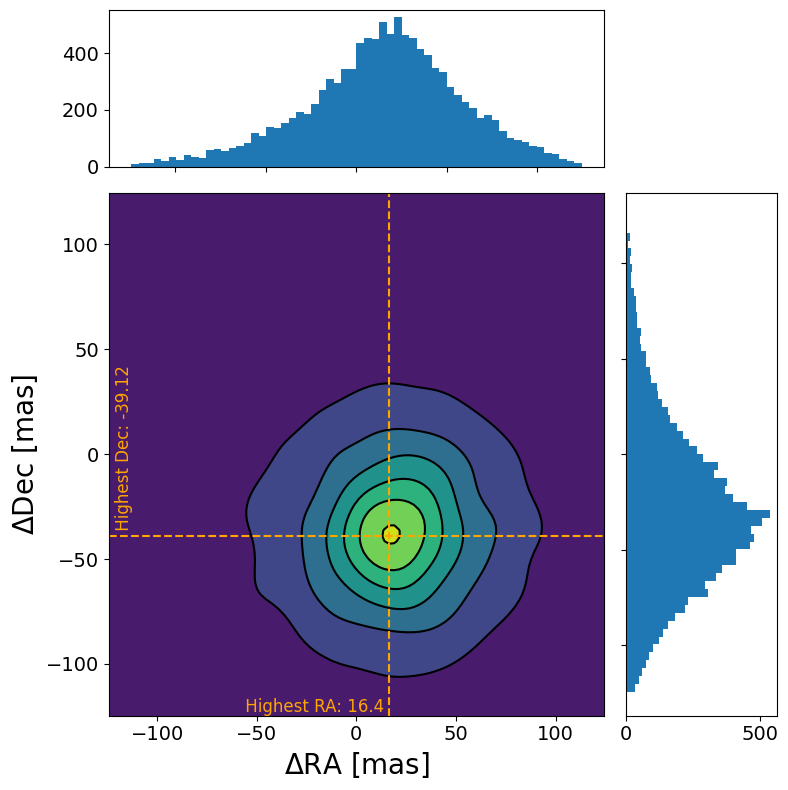

Calculating offsets between acs_I_030mas_078_sci.fits & A1......
Start crossmatching......
Crossmatching done......


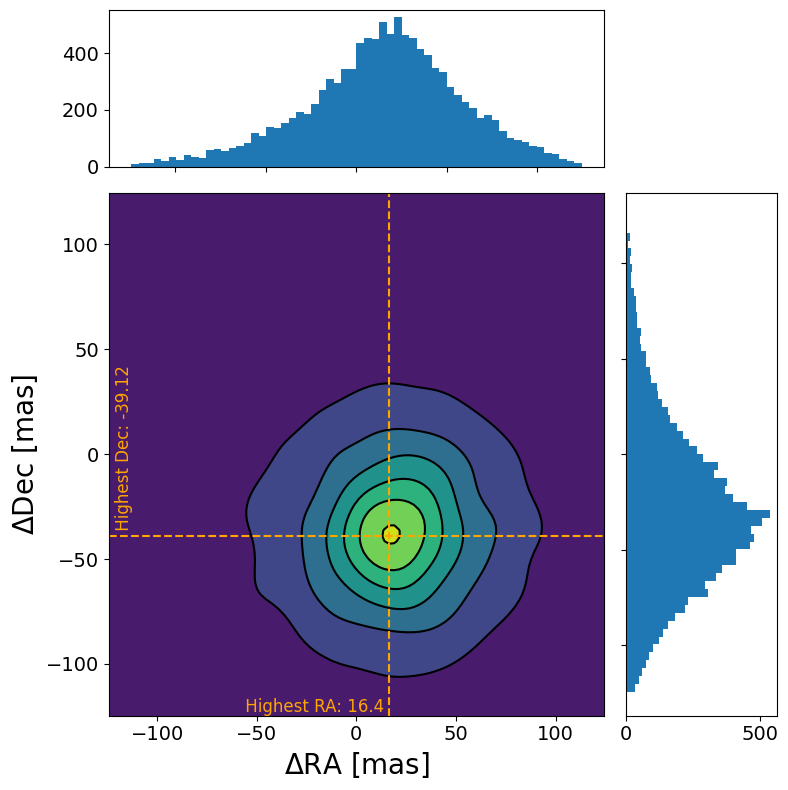

Calculating offsets between acs_I_030mas_068_sci.fits & A1......
Start crossmatching......
Crossmatching done......


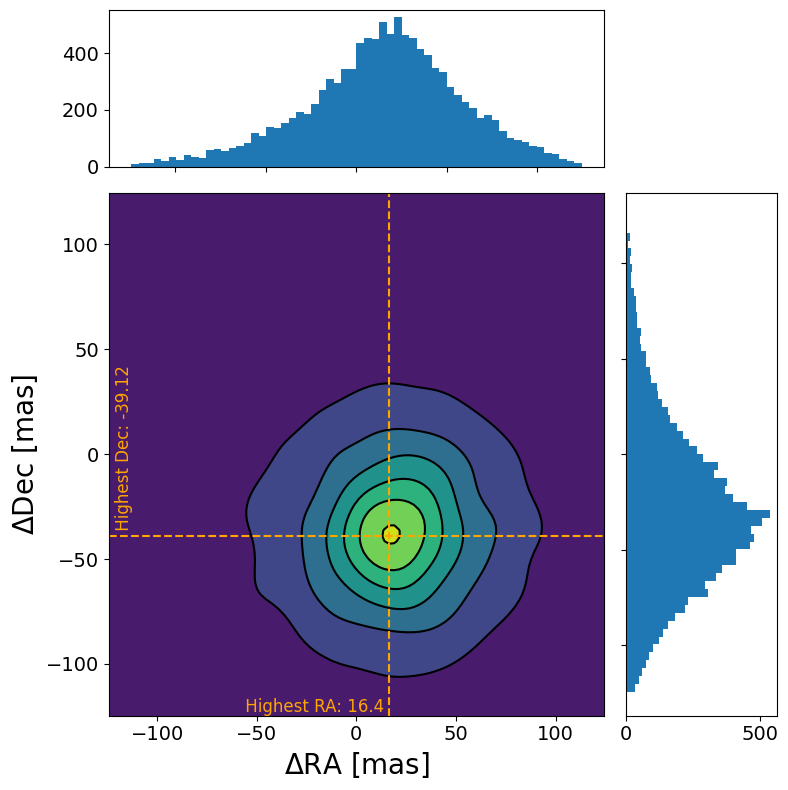

Calculating offsets between acs_I_030mas_066_sci.fits & A1......
Start crossmatching......
Crossmatching done......


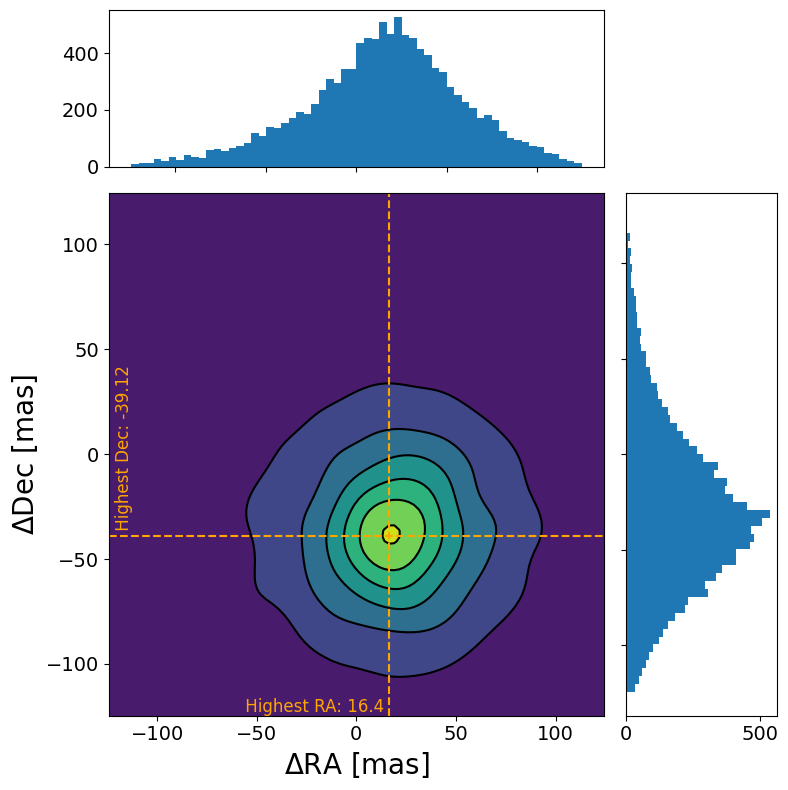

Calculating offsets between acs_I_030mas_053_sci.fits & A4......
Start crossmatching......
Crossmatching done......


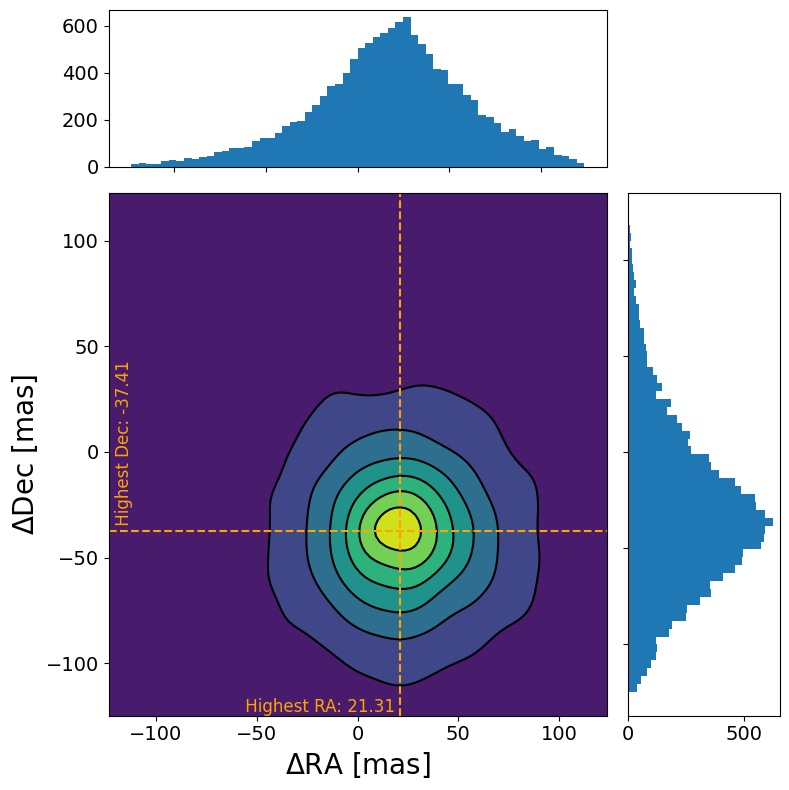

Calculating offsets between acs_I_030mas_052_sci.fits & A4......
Start crossmatching......
Crossmatching done......


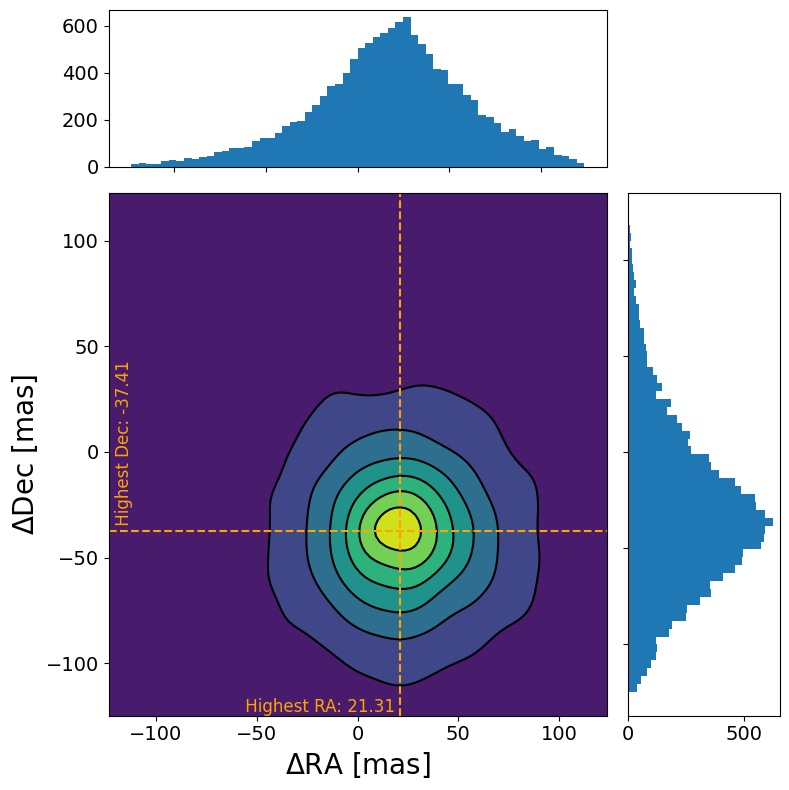

Calculating offsets between acs_I_030mas_064_sci.fits & A4......
Start crossmatching......
Crossmatching done......


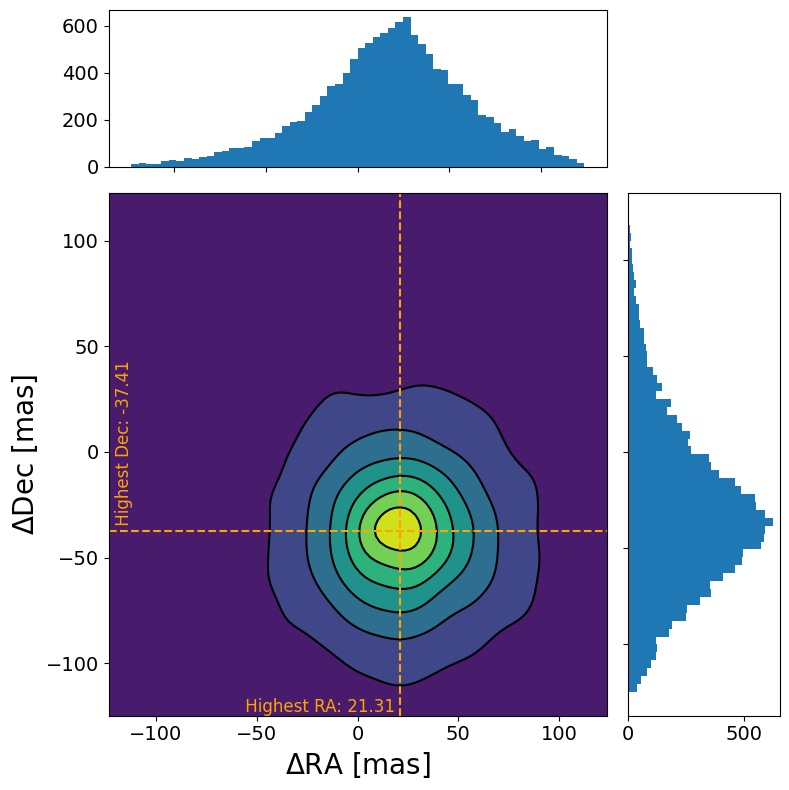

Calculating offsets between acs_I_030mas_065_sci.fits & A4......
Start crossmatching......
Crossmatching done......


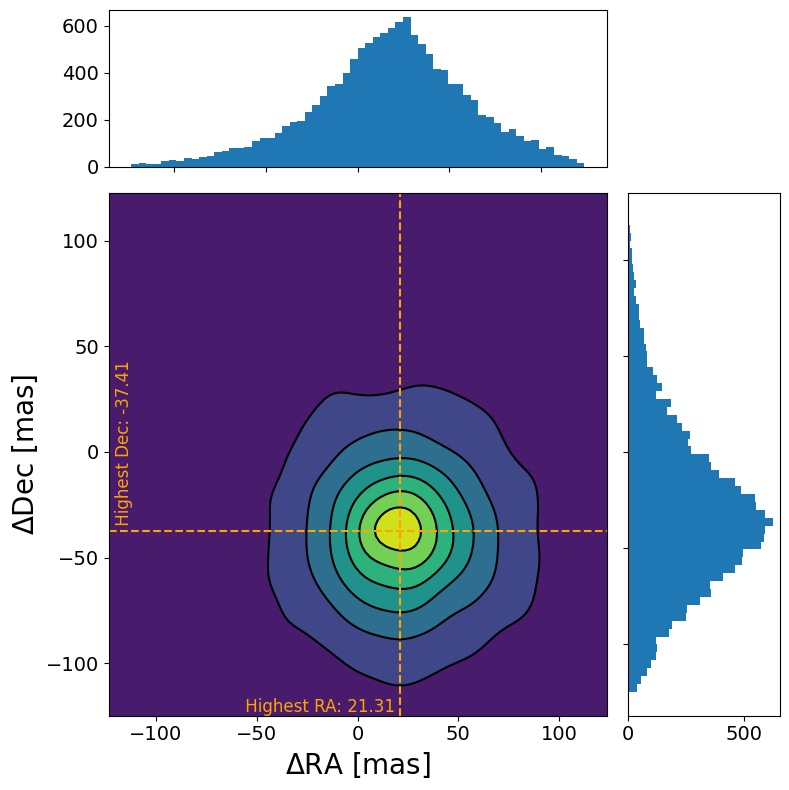

Calculating offsets between acs_I_030mas_040_sci.fits & A4......
Start crossmatching......
Crossmatching done......


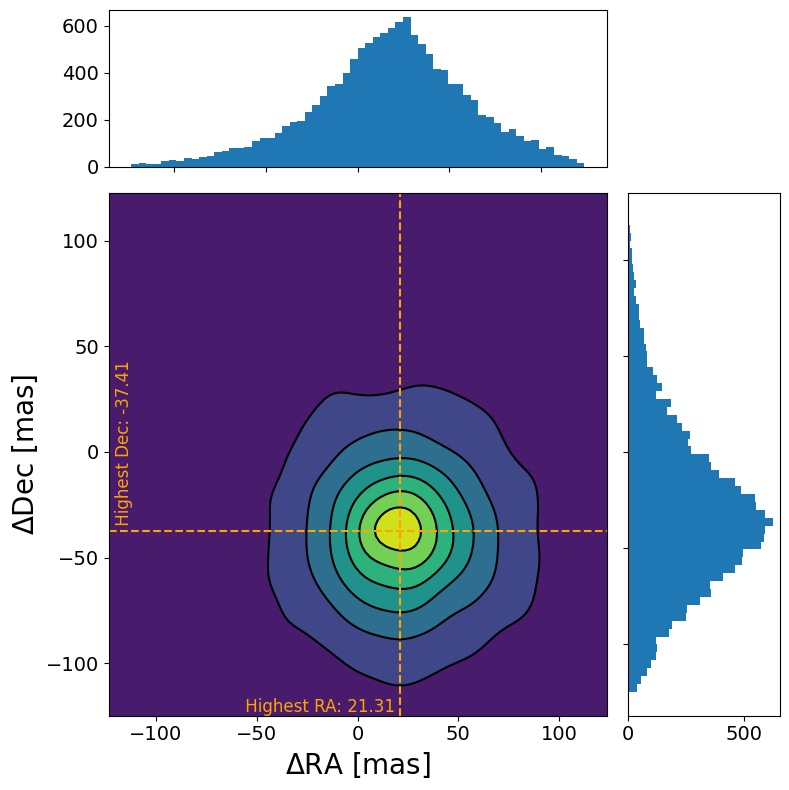

Calculating offsets between acs_I_030mas_041_sci.fits & A4......
Start crossmatching......
Crossmatching done......


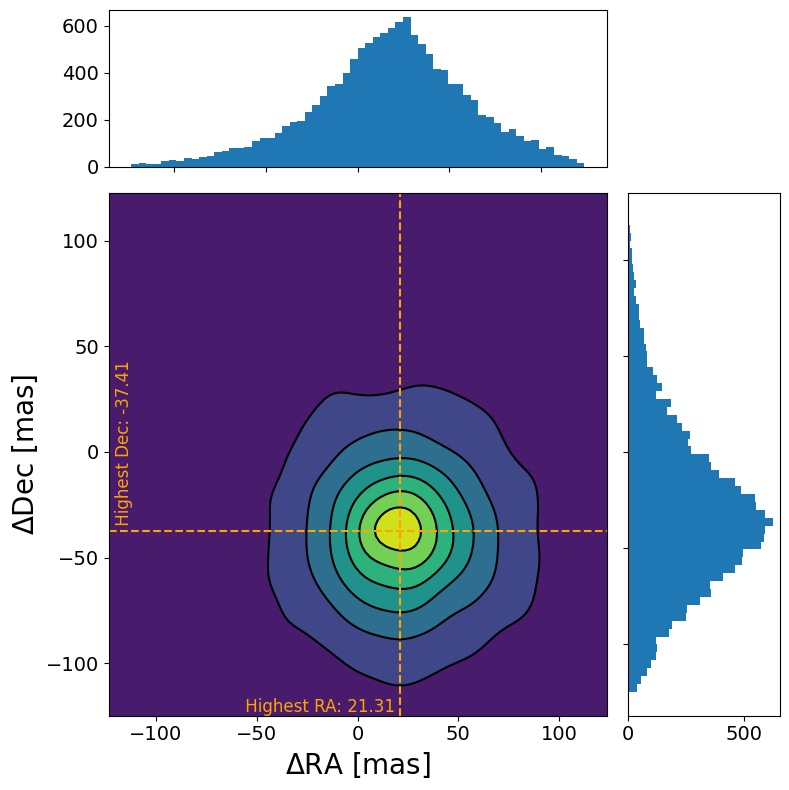

In [6]:
from definitions import calculate_JWST_HST_offsets

calculate_JWST_HST_offsets("30mas", "2024-04-28", 1)

### SEX on HST

#### WCS

In [7]:
import warnings
warnings.filterwarnings('ignore')

from definitions import make_colors
from definitions import find_HST_data

import matplotlib.patches as patches

from shapely.geometry import Point
from shapely.geometry import Polygon as shapely_polygon

from reproject import reproject_adaptive
from astropy.io import fits
from astropy.wcs import WCS

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utility import crossmatch
from definitions import map_HST_data

resolution = "30mas"
size = 150
date = "2024-04-28"
ind = 1

def COSMOS_cutout(total_cat, resolution="30mas", area="A1", size=150, kernel='hann'):
    # Load the JWST data needed for plotting
    images = {}
    headers = {}
    WCSs = {}
    pix_sizes = {}
    filters = ["F115W", "F150W", "F277W", "F444W"]
    a = []

    for f in range(len(filters)):
        with fits.open(f"./{resolution}/mosaic_nircam_{filters[f].lower()}_COSMOS-Web_{resolution}_{area}_v0_5_SCI.fits") as hdul:
            images[filters[f]] = hdul[1].data
            headers[filters[f]] = hdul[1].header
            WCSs[filters[f]] = WCS(hdul[1].header)
            pix_sizes[filters[f]] = np.sqrt(hdul[1].header['PIXAR_A2'])
            
    # Read the archived HST-JWST offset
    HST_offsets = json.load(open(f"./offsets/HST_JWST_F444W.json"))
    all_offsets = json.load(open(f"./offsets/{resolution}_{area}.json"))
    
    # Iterate over the input dataframe 
    for i, row in total_cat.iterrows():
        fig = plt.figure(figsize=(22, 11))
        
        # Plot HST F814W data as first image
        try:
            HST_file = find_HST_data((row['F444W_ALPHA_J2000'], row['F444W_DELTA_J2000']), area)
            HST_ra_offset, HST_dec_offset = HST_offsets[HST_file.split('/')[-1]]
            
            with fits.open(HST_file) as f:
                HST_image = f[0].data
                HST_header = f[0].header
                
            HST_WCS = WCS(HST_header)
            HST_pix_size = 0.03 # [arcsec]
            x_hst, y_hst = HST_WCS.all_world2pix(row[f'RA'], row[f'DEC'], 0)
            
            x_hst -= HST_ra_offset*3600/HST_pix_size
            y_hst -= HST_dec_offset*3600/HST_pix_size
            
            # print("Reprojecting HST image......")
            scale = 1.414
            
            y_start = max(0, int(y_hst - size*scale))
            y_end = min(HST_image.shape[0], int(y_hst + size*scale))
            x_start = max(0, int(x_hst - size*scale))
            x_end = min(HST_image.shape[1], int(x_hst + size*scale))

            cut_data_shape = (int(2*size*scale), int(2*size*scale))
            HST_img_center = np.full(cut_data_shape, np.nan)

            y_offset = max(0, int(size*scale - y_hst))
            x_offset = max(0, int(size*scale - x_hst))

            HST_img_center = HST_image[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = HST_image[y_start:y_end, x_start:x_end]
            
            HST_header["NAXIS1"] = HST_img_center.shape[1]
            HST_header["NAXIS2"] = HST_img_center.shape[0]
            headers["F444W"]["NAXIS1"] = HST_img_center.shape[1]
            headers["F444W"]["NAXIS2"] = HST_img_center.shape[0]
            
            HST_WCS = WCS(HST_header)
            JWST_WCS = WCS(headers["F444W"])
            # Measure the rotation of the JWST WCS
            theta = -np.arctan(JWST_WCS.wcs.pc[1, 0]/JWST_WCS.wcs.pc[0, 0])
            
            # Re-define the input and output WCS by changing the rotation angle
            input_wcs = HST_WCS.deepcopy()
            input_wcs.wcs.crpix = HST_img_center.shape[1]/2, HST_img_center.shape[0]/2
            input_wcs.wcs.cdelt = HST_pix_size/3600, HST_pix_size/3600
            
            output_wcs = input_wcs.deepcopy()
            output_wcs.wcs.crpix = HST_img_center.shape[1]/2, HST_img_center.shape[0]/2
            output_wcs.wcs.pc = [[-np.cos(theta), 
                                np.sin(theta)], 
                                [np.sin(theta), 
                                np.cos(theta)]]
            output_wcs.wcs.cdelt = HST_pix_size/3600/scale, HST_pix_size/3600/scale

            # Define the shape of the output image
            shape_out = (HST_img_center.shape[1], HST_img_center.shape[0])
            # print(shape_out, HST_img_center.shape, cut_data_shape)
            
            # Reproject the HST image on newly defined WCS  
            HST_img_center = reproject_adaptive((HST_img_center, input_wcs),
                                                output_wcs, shape_out=shape_out,
                                                kernel=kernel,
                                                return_footprint=False)
            
            ax = fig.add_subplot(2, 5, 1, projection=output_wcs)
            ax.imshow(HST_img_center,
                        cmap='viridis',
                        vmax=np.nanpercentile(HST_img_center, 99),
                        vmin=np.nanpercentile(HST_img_center, 10)
                        )
            
            # Plot center indicator of the center of the image
            ax.plot([size*scale, size*scale], [size*scale+0.5/HST_pix_size, size*scale+1/HST_pix_size], color='red', lw=3)
            ax.plot([size*scale+0.5/HST_pix_size, size*scale+1/HST_pix_size], [size*scale, size*scale], color='red', lw=3)
            
            # mag = round(row[f'{filters[f]}_MAG_AUTO'], 3)
            # mag_err = round(row[f'{filters[f]}_MAGERR_AUTO'], 3)
            ax.set_title("F814W", fontsize=30)

            # Hiding x and y axis ticks on regular axis
            ax.coords[0].set_ticks_visible(False)
            ax.coords[0].set_ticklabel_visible(False)
            ax.coords[1].set_ticks_visible(False)
            ax.coords[1].set_ticklabel_visible(False)
            
        except Exception as e:
            print(str(e))
            a.append((row['RA'], row['DEC']))
            pass
        
        # set the super title
        fig.suptitle(f"ID: {i} {round(row['RA'], 5)} {round(row['DEC'], 5)}", fontsize=30)
        
        # plot data from JWST
        for f in range(len(filters)):
            ax = fig.add_subplot(2, 5, f+2, projection=WCSs[filters[f]])
            img_data = images[filters[f]]
            # print(img_data.shape)
            
            # Calibrate the coordinate to F444W image
            ra_offset, dec_offset = all_offsets[filters[f]]
            # print(ra_offset, dec_offset)
            x_single = row[f'{filters[f]}_X_IMAGE'] - ra_offset*3600/pix_sizes[filters[f]]
            y_single = row[f'{filters[f]}_Y_IMAGE'] - dec_offset*3600/pix_sizes[filters[f]]
            # print(x_single, y_single)
            
            # Plot the image
            y_start = max(0, int(y_single - size))
            y_end = min(img_data.shape[0], int(y_single + size))
            x_start = max(0, int(x_single - size))
            x_end = min(img_data.shape[1], int(x_single + size))

            cut_data_shape = (2*size, 2*size)
            img_center = np.full(cut_data_shape, np.nan)

            y_offset = max(0, int(size - y_single))
            x_offset = max(0, int(size - x_single))

            img_center[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = img_data[y_start:y_end, x_start:x_end]
            
            ax.imshow(img_center, 
                    vmax=np.nanpercentile(img_center.flatten(), 99), 
                    vmin=np.nanpercentile(img_center.flatten(), 10)
                    )

            # Plot indicator of the center of the image
            ax.plot([size, size], [size+0.5/pix_sizes[filters[f]], size+1/pix_sizes[filters[f]]], color='red', lw=3)
            ax.plot([size+0.5/pix_sizes[filters[f]], size+1/pix_sizes[filters[f]]], [size, size], color='red', lw=3)

            mag = round(row[f'{filters[f]}_MAG_AUTO'], 3)
            mag_err = round(row[f'{filters[f]}_MAGERR_AUTO'], 3)
            ax.set_title(f"{filters[f]} \n {mag}$\pm${mag_err}" , fontsize=30)
            
            # Hiding x and y axis ticks
            ax.coords[0].set_ticks_visible(False) 
            ax.coords[0].set_ticklabel_visible(False) 
            ax.coords[1].set_ticks_visible(False)
            ax.coords[1].set_ticklabel_visible(False)
            
            # ax.set_xlabel(f"", fontsize=26)
                        
            # # Plot the Radius vs Magnitude plot
            # ax = fig.add_subplot(2, 5, f+7)
            # ax.scatter(target[f'{filters[f]}_PETRO_RADIUS'] * target[f'{filters[f]}_A_IMAGE'], 
            # target[f'{filters[f]}_MAG_PETRO'], s=50, label=f'{filters[f]}',
            # alpha=0.7, edgecolors='none', c='gray')

            # ax.scatter(row[f'{filters[f]}_PETRO_RADIUS'] * row[f'{filters[f]}_A_IMAGE'],
            #             row[f'{filters[f]}_MAG_PETRO'], s=40, label=f'{filters[f]}',
            #             alpha=1, edgecolors='none', c='red')
            
            # # axes labels & title & ticks size
            # ax.set_xlabel('PETRO_RADIUS [pix]', fontsize=26)
            # if f+7 == 7:
            #     ax.set_ylabel('MAG_PETRO [AB Mag]', fontsize=26)
            # ax.set_title(f'{filters[f]}', fontsize=30)
            # ax.tick_params(axis='both', which='major', labelsize=20)
            # ax.invert_yaxis()
            # ax.set_xlim(0, 125)
            # ax.set_ylim(28.5, 21)
            
        plt.savefig(f"./cutouts/{area}_{resolution}_{i}.png")
        
    return a

def COSMOS_Webb_dropouts(resolution, area, date, ind)-> pd.DataFrame:
    """
    This function is used to find the dropouts in the COSMOS-Webb catalog.
    """
    color_115_150, color_150_277, color_277_444, total_cat = make_colors(resolution, area, date, ind)

    H_vertices_115 = [(-10, 1), (0, 1), (1, 2), (1, 10), (-10, 10)]
    H_selection_115 = patches.Polygon(H_vertices_115, closed=True, color='green', alpha=0.45)
    poly115 = shapely_polygon(H_vertices_115)

    index = []
    # If the color is satisfied with the selection, plot the cutout
    for i, z in enumerate(zip(color_115_150, color_150_277)):
        if Point(z[1], z[0]).within(poly115):
            index.append(i)

    # select targets based on the index then sort the targets by ra
    target = total_cat.iloc[index]
    target = target.sort_values("RA")
    
    return target

#### Dropout Cat

In [ ]:
resolution = "30mas"
size = 150
date = "2024-04-28"
ind = 1
dropout_pd = pd.DataFrame()

for area in ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10"]:
    try:
        print(area, "start")
        cat = COSMOS_Webb_dropouts(resolution, area, date, ind)
        # add a new column for the area
        cat["area"] = area
        cat.rename(columns={"F444W_NUMBER": "F444W_ID"})
        # concat the dropouts in each area
        dropout_pd = pd.concat([dropout_pd, cat])
        print(area, "done")
        
    except Exception as e:
        print(e)
        pass
    
dropout_pd.to_csv(f"./catalogs/All_dropouts.csv", index=False)

#### Crossmatch with C2020

In [54]:
COSMOS_csv = pd.read_csv(f"./catalogs/COSMOS_2020_cut.csv")
matched_sources = crossmatch(
                            dropout_pd,
                            COSMOS_csv,
                            max_sep=0.15,
                            include_unmatched=True
                            )

candidates = matched_sources[~np.isnan(matched_sources["F444W_ALPHA_J2000"])]
no_HST_candidates = candidates[np.isnan(matched_sources["ID"])]
print(len(dropout_pd), len(candidates), len(no_HST_candidates))

Start crossmatching......
Crossmatching done......
3226 3226 1503


In [2]:
no_HST_candidates = pd.read_csv(f"./catalogs/All_dropouts_no_HST_Foreground.csv")

# Block Foreground Galaxies
foreground_galaxies = [(150.0421, 2.1578, 0.01)] # (RA, Dec, radius) [deg]

for galaxy in foreground_galaxies:
    mask_candidates = no_HST_candidates[(no_HST_candidates["RA"] > galaxy[0]+galaxy[2])
                                      | (no_HST_candidates["RA"] < galaxy[0]-galaxy[2])
                                      | (no_HST_candidates["DEC"] > galaxy[1]+galaxy[2])
                                      | (no_HST_candidates["DEC"] < galaxy[1]-galaxy[2])]

mask_candidates.to_csv(f"./catalogs/mask_candidates.csv", index=False)

#### RA-Dec plot

Start crossmatching......
Crossmatching done......


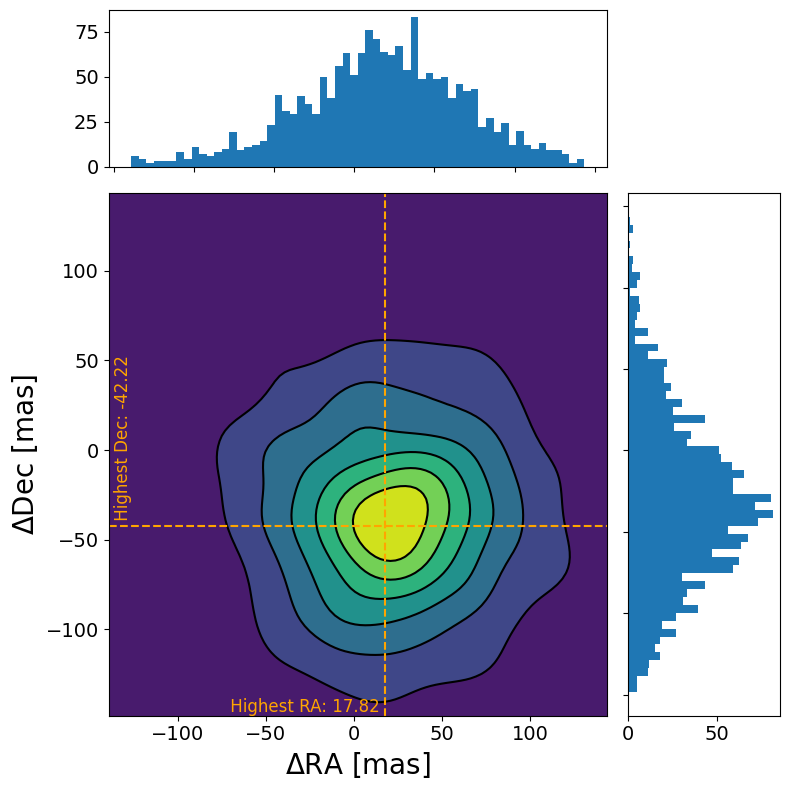

(0.07359852250779236, 17.82, -42.22)

In [55]:
from utility import ra_dec_plot

ra_dec_plot(
            max_sep=0.15,
            treat_sep=False,
            csv1=COSMOS_csv[["ALPHA_J2000", "DELTA_J2000"]],
            csv2=matched_sources[['Alpha_J2000', 'Delta_J2000']].dropna(),
            save=False
        )

#### Spatial Density

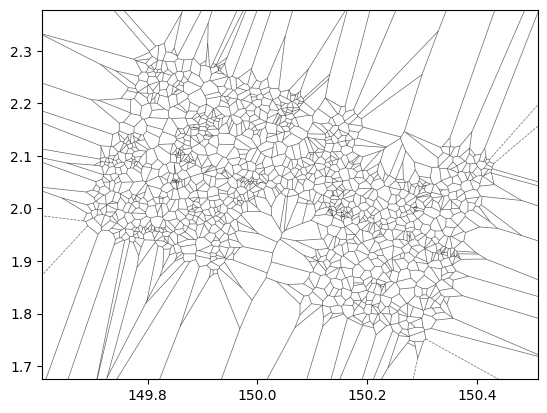

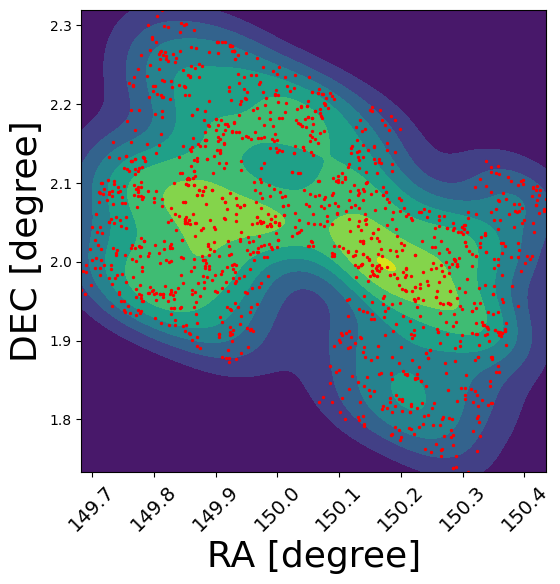

In [83]:
# use Voronoi Density Estimator to plot a countinueous density map
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import matplotlib.pyplot as plt

# make a Voronoi diagram
points = mask_candidates[["F444W_ALPHA_J2000", "F444W_DELTA_J2000"]].values
vor = Voronoi(points)

r = 0.01
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='black',
                        line_width=0.5, line_alpha=0.6, point_size=0)
# plt.axvline(150.0421+r, color='red', lw=0.5)
# plt.axhline(2.1578+r, color='red', lw=0.5)
plt.show()

# make a meshgrid
x = np.linspace(min(mask_candidates["F444W_ALPHA_J2000"]), max(mask_candidates["F444W_ALPHA_J2000"]), 400)
y = np.linspace(min(mask_candidates["F444W_DELTA_J2000"]), max(mask_candidates["F444W_DELTA_J2000"]), 400)
X, Y = np.meshgrid(x, y)

# make a kernel density estimator
kde = gaussian_kde(points.T)
Z = kde(np.vstack([X.ravel(), Y.ravel()]))
Z = Z.reshape(X.shape)

plt.figure(figsize=(6, 6))
plt.contourf(X, Y, Z, cmap="viridis")
plt.scatter(mask_candidates["F444W_ALPHA_J2000"], mask_candidates["F444W_DELTA_J2000"], s=2, c='red')
# plt.scatter(COSMOS_csv["ALPHA_J2000"], COSMOS_csv["DELTA_J2000"], s=2, c='red')
plt.xlabel("RA [degree]", fontsize=26)
plt.ylabel("DEC [degree]", fontsize=26)
plt.xticks(fontsize=14, rotation=45)

plt.show()

#### Check coordinates

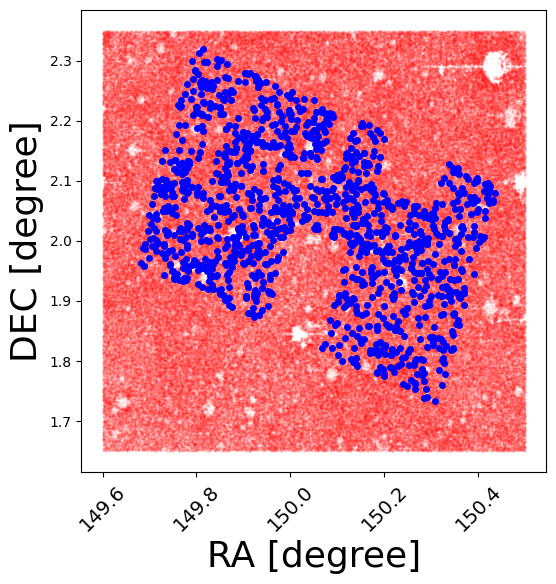

In [84]:
plt.figure(figsize=(6, 6))
plt.scatter(COSMOS_csv["ALPHA_J2000"], COSMOS_csv["DELTA_J2000"], s=0.1, alpha=0.2, c='red')
plt.scatter(mask_candidates["RA"], mask_candidates["DEC"], s=16, alpha=1, c='blue')
plt.xlabel("RA [degree]", fontsize=26)
plt.ylabel("DEC [degree]", fontsize=26)
plt.xticks(fontsize=14, rotation=45)

plt.show()

#### Cutouts

Search A1 in HST image......
Finding source in which tiles......
Search A1 in HST image......
Finding source in which tiles......
Search A1 in HST image......
Finding source in which tiles......
Search A1 in HST image......
Finding source in which tiles......


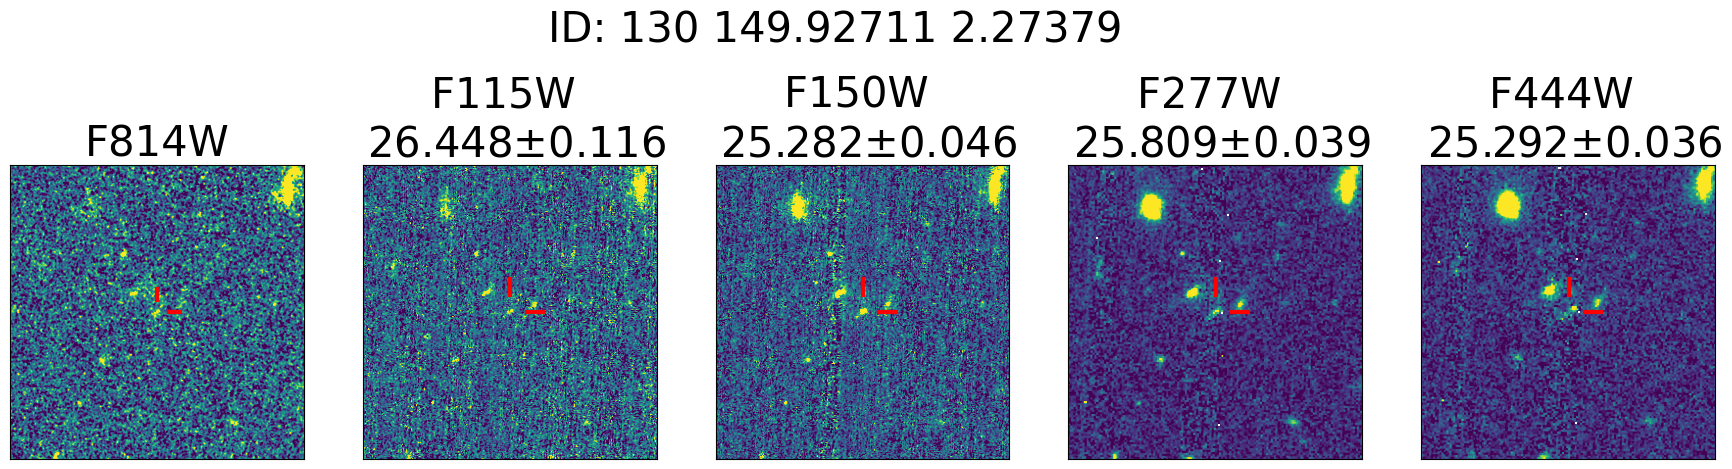

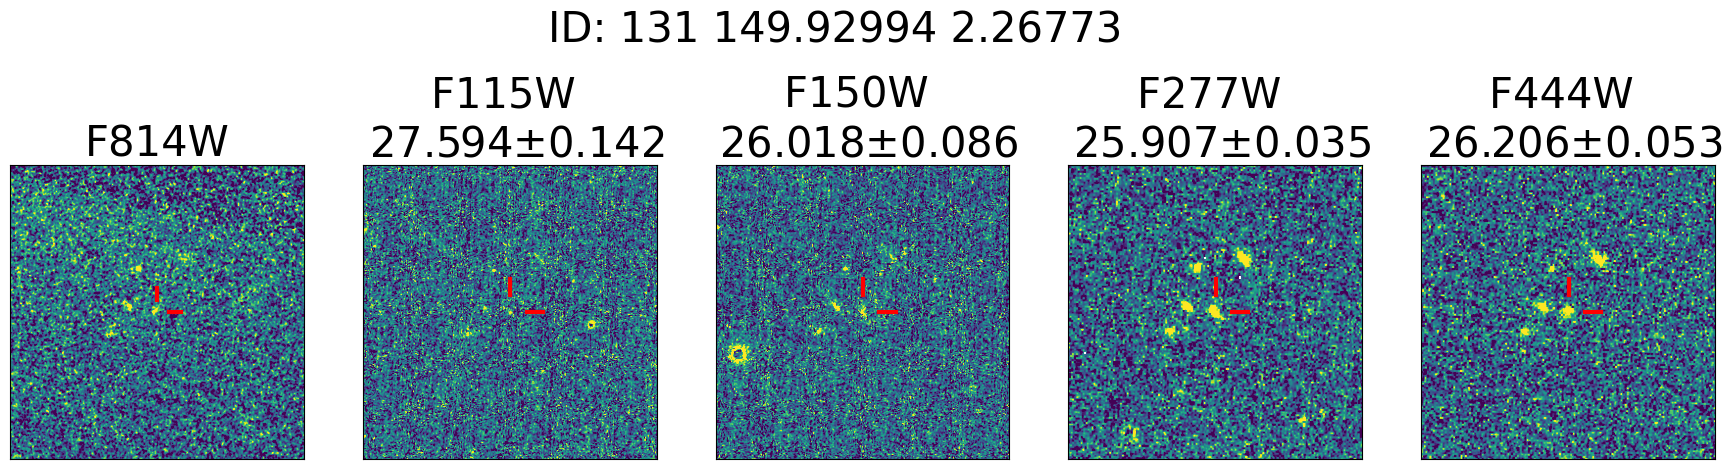

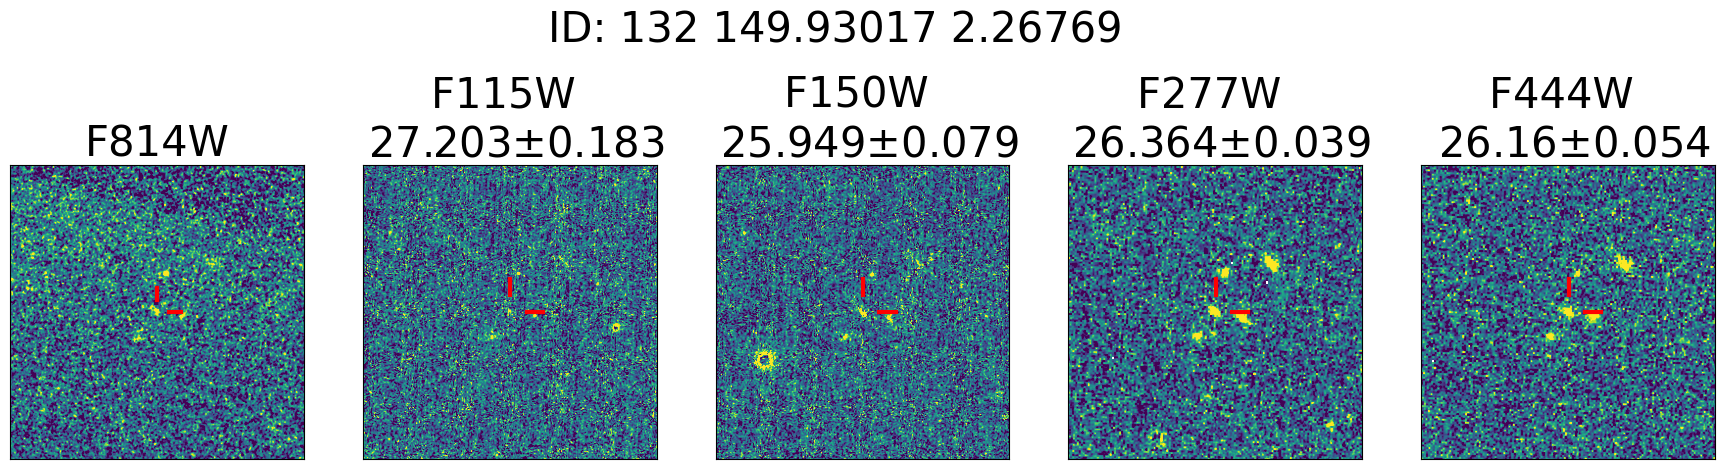

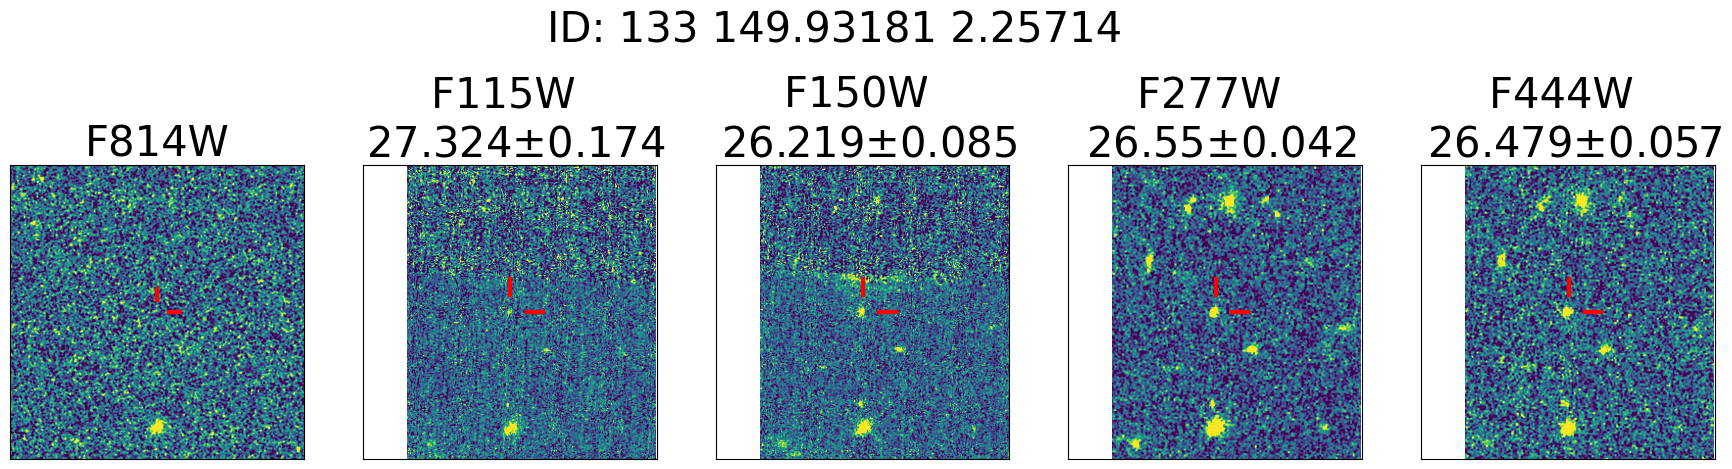

In [8]:
for area in ["A1"]:#, "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10"]:
    bb = COSMOS_cutout(mask_candidates[mask_candidates["area"] == "A1"][-4:], resolution, area, size=150)
    break

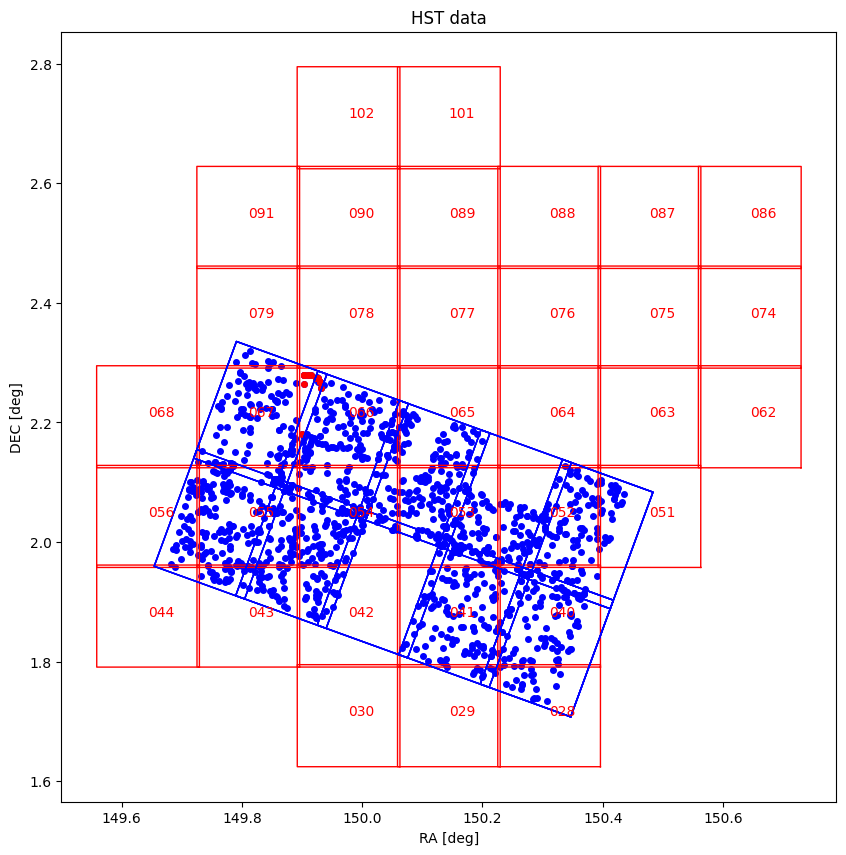

In [27]:

from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Polygon as shapely_polygon

from reproject import reproject_adaptive

import json, glob

def find_HST_data():
    HST_files = sorted(glob.glob(f"./others/HST/*.fits"))
    fig, ax = plt.subplots(figsize=(10, 10))
    # ax.set_xlim(150.0, 150.1)
    # ax.set_ylim(2.15, 2.16)
    ax.set_xlabel("RA [deg]")
    ax.set_ylabel("DEC [deg]")
    ax.set_title("HST data")
    
    for f in HST_files:
        with fits.open(f) as hdul:
            header = hdul[0].header
            wcs = WCS(header)
            shape = hdul[0].data.shape
        
        # plot 4 corners of each HST image as a polygon
        ra_c1, dec_c1 = wcs.wcs_pix2world(0, 0, 0)
        ra_c2, dec_c2 = wcs.wcs_pix2world(shape[0], 0, 0)
        ra_c3, dec_c3 = wcs.wcs_pix2world(0, shape[1], 0)
        ra_c4, dec_c4 = wcs.wcs_pix2world(shape[0], shape[1], 0)

        # construct a rectangle using the coordinates
        hst_polygon = shapely_polygon([(ra_c1, dec_c1), (ra_c2, dec_c2), (ra_c4, dec_c4), (ra_c3, dec_c3)])

        # annotate the center of the image
        ax.text((ra_c1+ra_c4)/2, (dec_c1+dec_c4)/2, f.split('/')[-1].split('_')[-2], fontsize=10, color='red')
        
        # plot the polygon
        ax.plot(*hst_polygon.exterior.xy, color='red', lw=1)
        
    # JWST data
    for ff in ["F115W", "F150W", "F277W", "F444W"]:
        JWST_files = sorted(glob.glob(f"./30mas/*{ff.lower()}*A*.fits"))
        
        for j in JWST_files:
            with fits.open(j) as hdul:
                header = hdul[1].header
                wcs = WCS(header)
                shape = hdul[1].data.shape
                
            # plot 4 corners of each JWST image as a polygon
            ra_c1, dec_c1 = wcs.wcs_pix2world(0, 0, 0)
            ra_c2, dec_c2 = wcs.wcs_pix2world(shape[1], 0, 0)
            ra_c3, dec_c3 = wcs.wcs_pix2world(0, shape[0], 0)
            ra_c4, dec_c4 = wcs.wcs_pix2world(shape[1], shape[0], 0)
            
            # construct a rectangle using the coordinates
            jwst_polygon = shapely_polygon([(ra_c1, dec_c1), (ra_c2, dec_c2), (ra_c4, dec_c4), (ra_c3, dec_c3)])
            
            # plot the polygon
            ax.plot(*jwst_polygon.exterior.xy, color='blue', lw=1)
        
    ax.scatter(mask_candidates["RA"], mask_candidates["DEC"], s=16, alpha=1, c='blue')
    ax.scatter([b[0] for b in bb], [b[1] for b in bb], s=16, alpha=1, c='red')
find_HST_data()

### SED

In [1]:
import pandas as pd
from utility import AB_2_mJy, flux_error_to_mag_error

default_cat = pd.read_csv(f"./catalogs/Z_9_Candidates_for_SED.csv")
cat = pd.read_csv(f"./catalogs/All_dropouts_no_HST_Foreground.csv")

In [2]:
# erase all rows from the default catalog
cigale_cat = default_cat.drop(default_cat.index)

# read RA and DEC from cat to create ID
cigale_cat["id"] = [str(round(r['RA'], 7)) + "_" + str(round(r['DEC'], 7)) for i, r in cat.iterrows()]

# place upper limits
cigale_cat['hst.wfc.F814W'] = default_cat['hst.wfc.F814W'].values[0]
cigale_cat['hst.wfc.F814W_err'] = default_cat['hst.wfc.F814W_err'].values[0]

cigale_cat['spitzer.irac.ch1'] = default_cat['spitzer.irac.ch1'].values[0]
cigale_cat['spitzer.irac.ch1_err'] = default_cat['spitzer.irac.ch1_err'].values[0]
cigale_cat['spitzer.irac.ch2'] = default_cat['spitzer.irac.ch2'].values[0]
cigale_cat['spitzer.irac.ch2_err'] = default_cat['spitzer.irac.ch2_err'].values[0]

cigale_cat['subaru.hsc.z'] = default_cat['subaru.hsc.z'].values[0]
cigale_cat['subaru.hsc.z_err'] = default_cat['subaru.hsc.z_err'].values[0]
cigale_cat['subaru.hsc.y'] = default_cat['subaru.hsc.y'].values[0]
cigale_cat['subaru.hsc.y_err'] = default_cat['subaru.hsc.y_err'].values[0]

cigale_cat['vista.vircam.Y'] = default_cat['vista.vircam.Y'].values[0]
cigale_cat['vista.vircam.Y_err'] = default_cat['vista.vircam.Y_err'].values[0]
cigale_cat['vista.vircam.J'] = default_cat['vista.vircam.J'].values[0]
cigale_cat['vista.vircam.J_err'] = default_cat['vista.vircam.J_err'].values[0]
cigale_cat['vista.vircam.H'] = default_cat['vista.vircam.H'].values[0]
cigale_cat['vista.vircam.H_err'] = default_cat['vista.vircam.H_err'].values[0]
cigale_cat['vista.vircam.Ks'] = default_cat['vista.vircam.Ks'].values[0]
cigale_cat['vista.vircam.Ks_err'] = default_cat['vista.vircam.Ks_err'].values[0]

cigale_cat["redshift"] = -1

# replace jwst fluxes
cigale_cat['jwst.nircam.F115W'] = AB_2_mJy(cat['F115W_MAG_AUTO'].values)
cigale_cat['jwst.nircam.F115W_err'] = flux_error_to_mag_error(cat['F115W_MAG_AUTO'], cat['F115W_MAGERR_AUTO'].values)
cigale_cat['jwst.nircam.F150W'] = AB_2_mJy(cat['F150W_MAG_AUTO'].values)
cigale_cat['jwst.nircam.F150W_err'] = flux_error_to_mag_error(cat['F150W_MAG_AUTO'], cat['F150W_MAGERR_AUTO'].values)
cigale_cat['jwst.nircam.F277W'] = AB_2_mJy(cat['F277W_MAG_AUTO'].values)
cigale_cat['jwst.nircam.F277W_err'] = flux_error_to_mag_error(cat['F277W_MAG_AUTO'], cat['F277W_MAGERR_AUTO'].values)
cigale_cat['jwst.nircam.F444W'] = AB_2_mJy(cat['F444W_MAG_AUTO'].values)
cigale_cat['jwst.nircam.F444W_err'] = flux_error_to_mag_error(cat['F444W_MAG_AUTO'], cat['F444W_MAGERR_AUTO'].values)

# remove the unnammed columns
cigale_cat = cigale_cat.drop(columns=['Unnamed: 0'])

print(cigale_cat)

                         id  redshift  hst.wfc.F814W  hst.wfc.F814W_err  \
0     149.7339446_2.1520231        -1       0.000048              -99.0   
1     149.7551034_2.1343412        -1       0.000048              -99.0   
2       149.756959_2.178568        -1       0.000048              -99.0   
3     149.7603505_2.2270098        -1       0.000048              -99.0   
4      149.7627215_2.151703        -1       0.000048              -99.0   
...                     ...       ...            ...                ...   
1387  150.3618579_1.9055839        -1       0.000048              -99.0   
1388  150.3640316_1.9101671        -1       0.000048              -99.0   
1389  150.3693398_1.9124161        -1       0.000048              -99.0   
1390  150.3693742_1.9147755        -1       0.000048              -99.0   
1391  150.3696221_1.8938643        -1       0.000048              -99.0   

      spitzer.irac.ch1  spitzer.irac.ch1_err  spitzer.irac.ch2  \
0             0.001096           

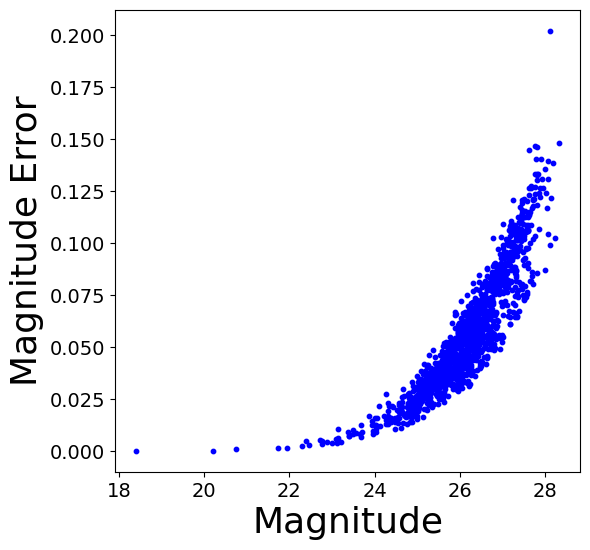

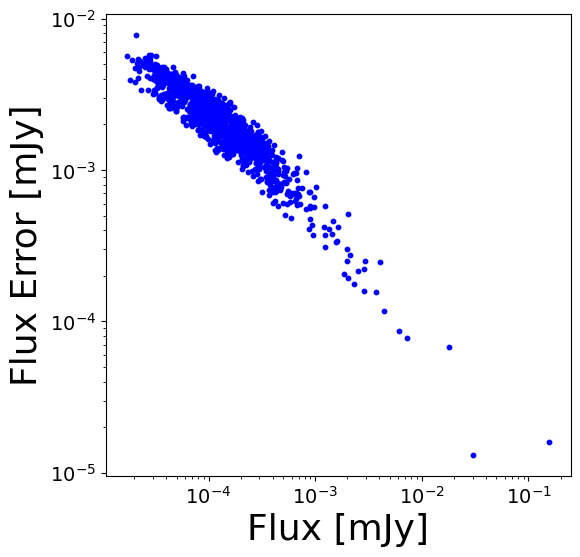

In [3]:
# plot mag vs mag err of cat
import matplotlib.pyplot as plt
import numpy as np

mag = cat['F444W_MAG_AUTO'].values
mag_err = cat['F444W_MAGERR_AUTO'].values

plt.figure(figsize=(6, 6))
plt.scatter(mag, mag_err, s=10, c='blue')
plt.xlabel("Magnitude", fontsize=26)
plt.ylabel("Magnitude Error", fontsize=26)
# plt.title(title, fontsize=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# flux vs flux err
flux = AB_2_mJy(mag)
flux_err = flux_error_to_mag_error(mag, mag_err)

plt.figure(figsize=(6, 6))
plt.scatter(flux, flux_err, s=10, c='blue')
plt.xlabel("Flux [mJy]", fontsize=26)
plt.ylabel("Flux Error [mJy]", fontsize=26)
# plt.title(title, fontsize=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.show()

### Check JWST Data

105.71392759729133 21857.931316101654
(24910, 19200)


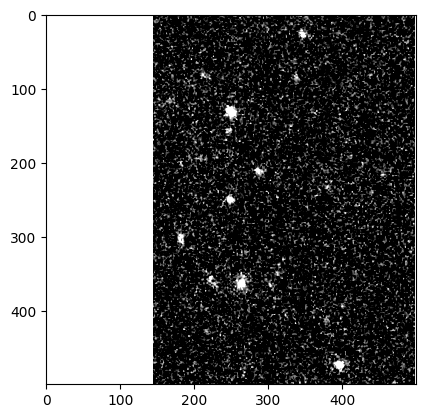

In [34]:
with fits.open(f"./30mas/mosaic_nircam_f444w_COSMOS-Web_30mas_A1_v0_5_SCI.fits") as hdul:
    data = hdul[1].data
    header = hdul[1].header
    JWST_wcs = WCS(header)

x_single, y_single = JWST_wcs.all_world2pix(149.93181, 2.25714, 0)
print(x_single, y_single)
print(data.shape)

size = 250

y_start = max(0, int(y_single - size))
y_end = min(data.shape[0], int(y_single + size))
x_start = max(0, int(x_single - size))
x_end = min(data.shape[1], int(x_single + size))

cut_data_shape = (2*size, 2*size)
cut_data = np.full(cut_data_shape, np.nan)

y_offset = max(0, int(size - y_single))
x_offset = max(0, int(size - x_single))

cut_data[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = data[y_start:y_end, x_start:x_end]

plt.imshow(cut_data, cmap='gray', vmin=np.nanpercentile(cut_data, 60), vmax=np.nanpercentile(cut_data, 99.5))

### Check HST Data

In [ ]:
with fits.open(f"./others/HST/mosaic_nircam_f444w_COSMOS-Web_30mas_A1_v0_5_SCI.fits") as hdul:
    data = hdul[1].data
    header = hdul[1].header
    JWST_wcs = WCS(header)

x_single, y_single = JWST_wcs.all_world2pix(149.93181, 2.25714, 0)
print(x_single, y_single)
print(data.shape)

size = 250

y_start = max(0, int(y_single - size))
y_end = min(data.shape[0], int(y_single + size))
x_start = max(0, int(x_single - size))
x_end = min(data.shape[1], int(x_single + size))

cut_data_shape = (2*size, 2*size)
cut_data = np.full(cut_data_shape, np.nan)

y_offset = max(0, int(size - y_single))
x_offset = max(0, int(size - x_single))

cut_data[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = data[y_start:y_end, x_start:x_end]

plt.imshow(cut_data, cmap='gray', vmin=np.nanpercentile(cut_data, 60), vmax=np.nanpercentile(cut_data, 99.5))